# Exploring Twinkles Run1 Data using MySQL tables

### Database tables
- I wanted `ForcedSource`, `CcdVisit`, and `Object` tables as described at the [LSST schema browser](https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=baseline), but the Stack [daf_ingest](https://github.com/lsst/daf_ingest) and [datarel](https://github.com/lsst/datarel) packages were basically unusable with `obs_lsstSim` data.
- Instead, I implemented a set of [interface classes](https://github.com/DarkEnergyScienceCollaboration/Twinkles/blob/issue/58/forced_source_db_ingest/python/desc/twinkles/db_table_access.py) to MySQL and ingested the Run1 985 visit data into my KIPAC MySQL tablespace, using the LSST baseline schemas:

```
MySQL [jc_desc]> show tables;   
+-------------------+
| Tables_in_jc_desc |
+-------------------+
| CcdVisit          |
| Chisq             |
| ForcedSource      |
| Object            |
+-------------------+
4 rows in set (0.00 sec)

MySQL [jc_desc]> select count(1) from Object;
+----------+
| count(1) |
+----------+
|    60554 |
+----------+
1 row in set (0.04 sec)

MySQL [jc_desc]> select count(1) from ForcedSource;
+----------+
| count(1) |
+----------+
| 46012049 |
+----------+
1 row in set (26.67 sec)

MySQL [jc_desc]>
```
- The Run1 985 visit data contain 60554 objects in the merged reference catalog and 46,012,049 sources in the 985 visits.
- I also wanted to select objects with different levels of variability, so I added a `Chisq` table and filled it with the chi-square values from fitting a constant flux to the `ForcedSource` u-band values.  [The script](https://github.com/jchiang87/desc_projects/blob/master/twinkles/chisq_dists.py) that does this is in my [desc_projects](https://github.com/jchiang87/desc_projects) repo.

```
MySQL [jc_desc]> describe Chisq;
+------------+------------+------+-----+---------+-------+
| Field      | Type       | Null | Key | Default | Extra |
+------------+------------+------+-----+---------+-------+
| objectId   | bigint(20) | NO   | PRI | 0       |       |
| filterName | char(1)    | NO   | PRI |         |       |
| chisq      | float      | YES  |     | NULL    |       |
| dof        | int(11)    | YES  |     | NULL    |       |
| chi2prob   | float      | YES  |     | NULL    |       |
+------------+------------+------+-----+---------+-------+
5 rows in set (0.00 sec)

MySQL [jc_desc]> select count(1) from Chisq where filterName='u' and dof=252 and chisq>1e5;
+----------+
| count(1) |
+----------+
|      629 |
+----------+
1 row in set (0.05 sec)

MySQL [jc_desc]> 
```
- I also added [some classes](https://github.com/DarkEnergyScienceCollaboration/Twinkles/blob/issue/58/forced_source_db_ingest/python/desc/twinkles/lightCurveFactory.py) to generate light curves in the LSST bands. (This code should probably be migrated to Monitor.)

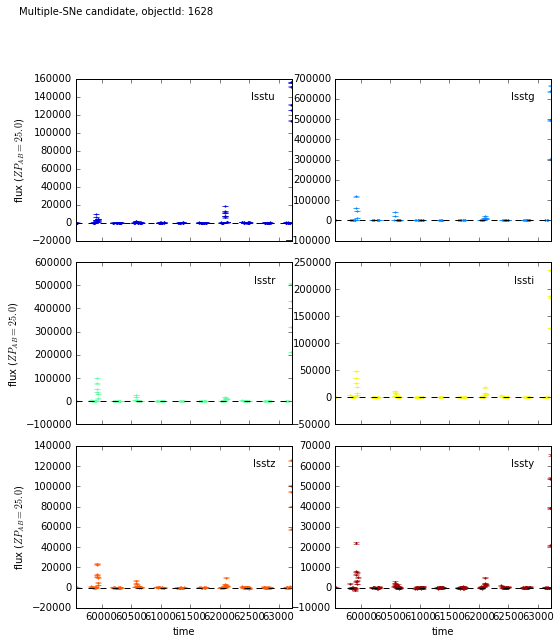

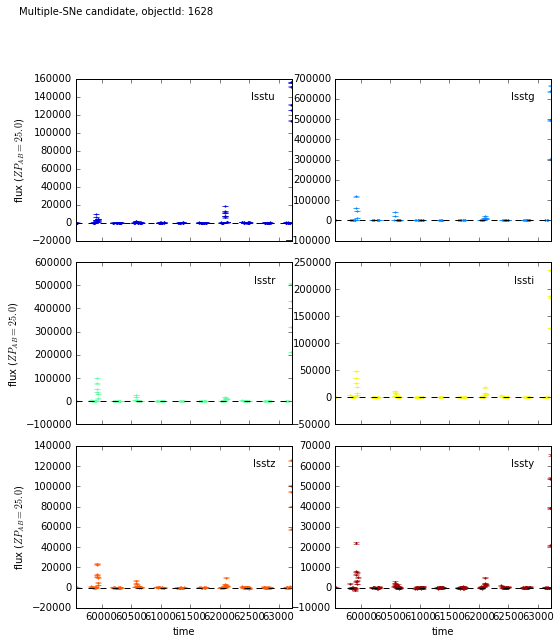

In [1]:
import matplotlib.pyplot as plt
import sncosmo
from desc.twinkles.lightCurveFactory import LightCurveFactory
%matplotlib inline
plt.ion()

lc_factory = LightCurveFactory(db='jc_desc', read_default_file='~/.my.cnf')

objectId = 1628
SN = lc_factory.create(objectId)
SN.plot(figtext='Multiple-SNe candidate, objectId: %i' % objectId)

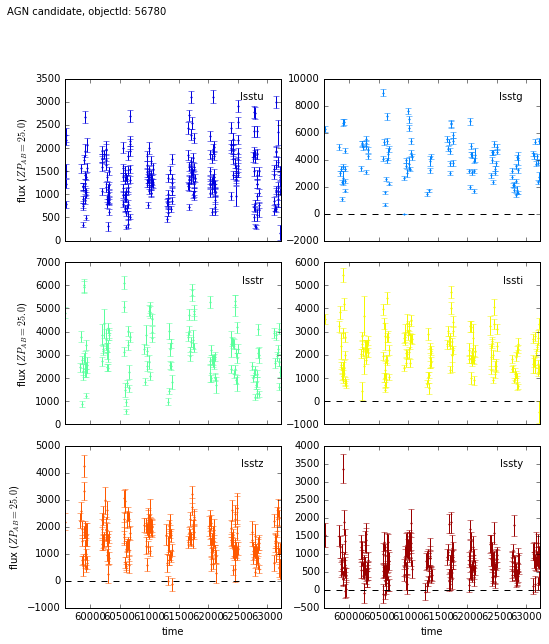

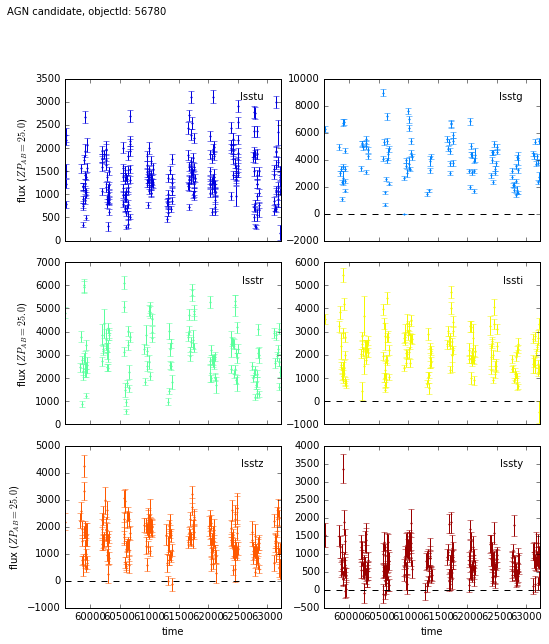

In [2]:
objectId = 56780
AGN = lc_factory.create(objectId)
AGN.plot(figtext='AGN candidate, objectId: %i' % objectId)

### Classifying Light Curves
- AGNs and SNe have distinctive and distinguishable light curves, but using the time-ordered fluxes directly, it's not clear which ML algorithm would be effective.
- Instead, I normalized the fluxes to their peak value and histogrammed them, noting that the multiple-SNe and AGN candidates would would have very different distributions.
- I then used K-means to group similar distributions.
- The u band was the best sampled, so I restricted the analysis to those data.

This is implemented in my [kmeans_uband.py script](https://github.com/jchiang87/desc_projects/blob/master/twinkles/kmeans_uband.py).

select cs.objectId from Chisq cs join Object obj
           on cs.objectId=obj.objectId
           where cs.filterName='u' and cs.dof=252 and cs.chisq>1e4
           and obj.numChildren=0
Found 4539 deblended variable objects for K-means analysis.


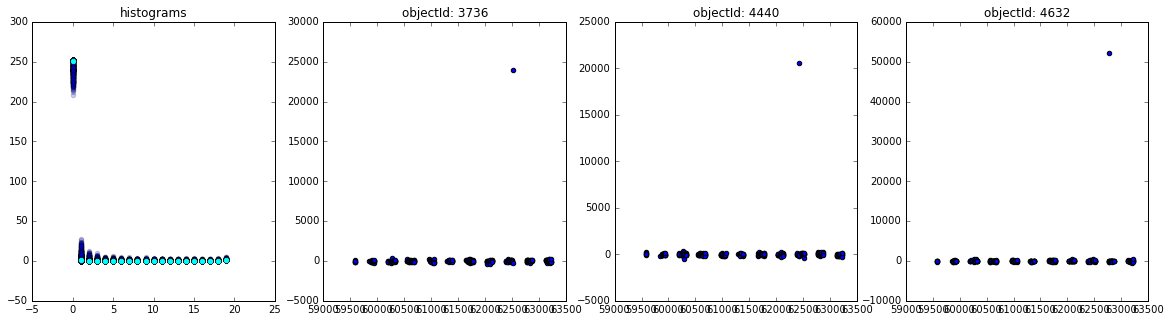

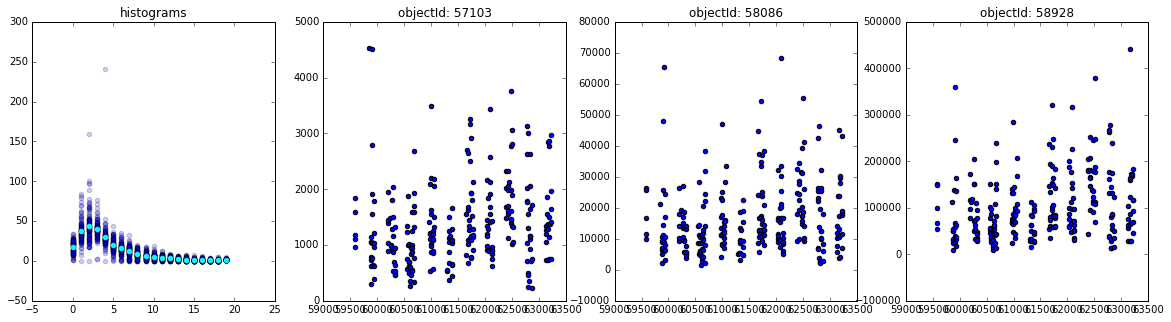

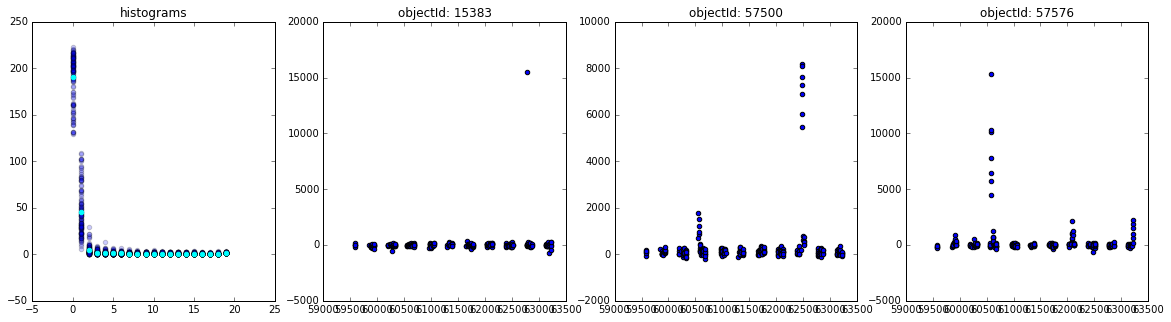

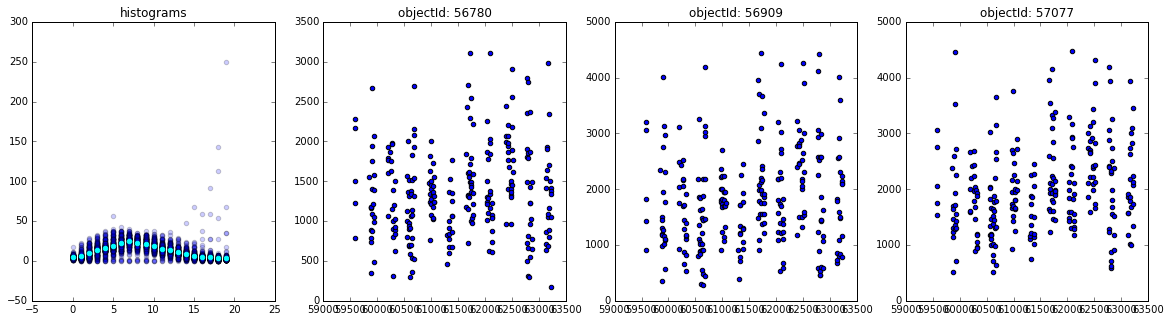

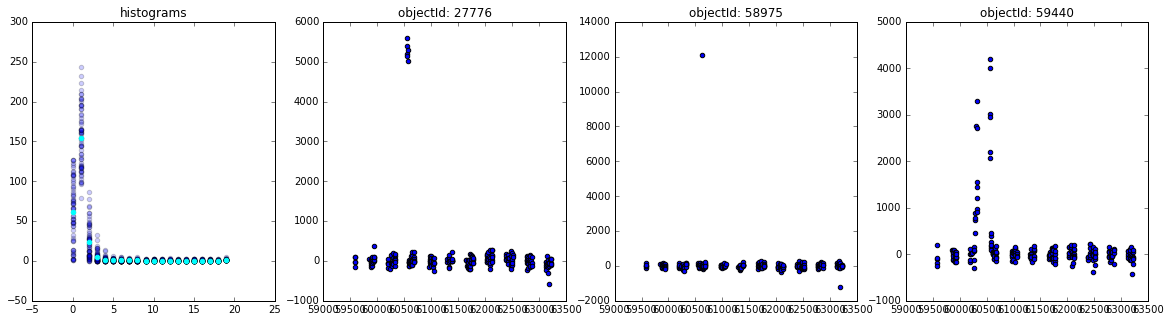

In [7]:
run kmeans_uband

I set the number of clusters to 5 and plot the histograms in each cluster (and their "center" in cyan) in the first column and then plot the light curves for the first three objects in the cluster.

The sources in the sample are restricted to those with `chisq > 1e4` and *without* a `parentObjectId`, i.e., it only includes deblended sources as measured by the Stack.  

Note that I added a `numChildren` column to the nominal `Object` table schema to identify the unblended objects.

### Postage Stamps and Object Positions
In Run1, multiple supernovae are associated with single galaxies, so several can appear in a single 10x10 arcsec postage stamp.  `ObjectId` 1628 appears to be a blend of several SNe:

```
MySQL [jc_desc]> select * from Object where objectId=1628 or parentObjectId=1628;
+----------+----------------+-------------+-------------+--------------+
| objectId | parentObjectId | numChildren | psRa        | psDecl       |
+----------+----------------+-------------+-------------+--------------+
|     1628 |              0 |          14 | 52.96140733 | -27.53871656 |
|    57573 |           1628 |           0 |  52.9614295 | -27.53873187 |
|    57574 |           1628 |           0 | 52.96130025 | -27.53956826 |
|    57575 |           1628 |           0 | 52.96141692 |   -27.539107 |
|    57576 |           1628 |           0 | 52.96169028 | -27.53937741 |
|    57577 |           1628 |           0 | 52.96039882 | -27.53961905 |
|    57578 |           1628 |           0 | 52.96031957 | -27.54072778 |
|    57579 |           1628 |           0 | 52.96033736 | -27.53815472 |
|    57580 |           1628 |           0 | 52.96077838 | -27.53940648 |
|    57581 |           1628 |           0 | 52.96040037 | -27.53999295 |
|    57582 |           1628 |           0 | 52.96038131 | -27.53853178 |
|    57583 |           1628 |           0 | 52.96068607 | -27.54068785 |
|    57584 |           1628 |           0 |  52.9607808 | -27.54010385 |
|    57585 |           1628 |           0 | 52.95982655 |  -27.5409999 |
|    57586 |           1628 |           0 | 52.96014623 | -27.54111035 |
+----------+----------------+-------------+-------------+--------------+
15 rows in set (0.05 sec)

MySQL [jc_desc]> 
```
Using the [plot_sources.py script](https://github.com/jchiang87/desc_projects/blob/master/twinkles/plot_sources.py), we can plot the light curves and 10x10 arcsec postage stamps for each band, overlaying the positions of the objects within those fields.

In [4]:
plt.rcParams['figure.figsize'] = 20, 30

52.96140733 -27.53871656
select obj.objectId, obj.psRa, obj.psDecl
           from Object obj join Chisq cs
           on obj.objectId=cs.objectId
           where cs.chisq > 0.000000e+00 and cs.dof>=0 and
            52.95984097 < obj.psRa and obj.psRa <  52.96297369 and
           -27.54010545 < obj.psDecl and obj.psDecl < -27.53732767
found 14 objects


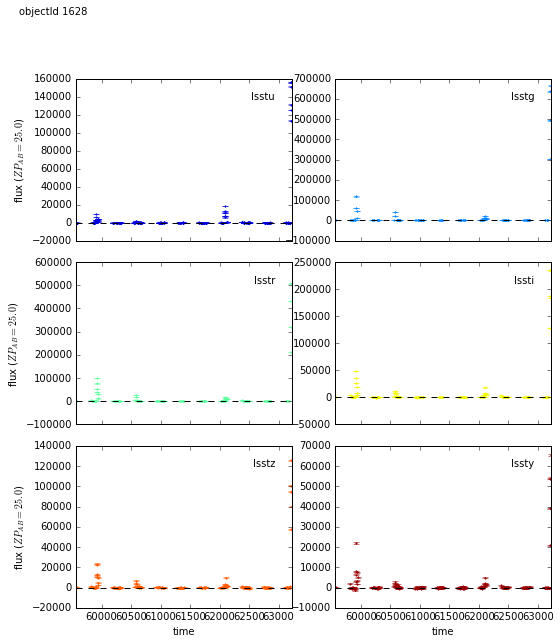

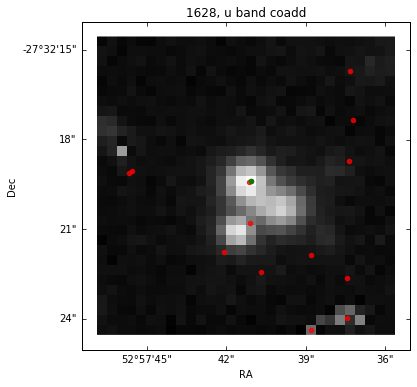

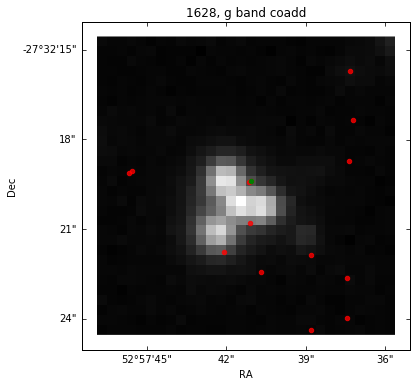

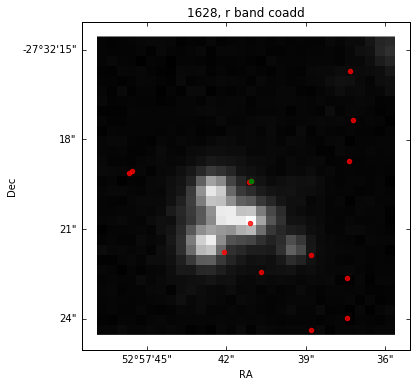

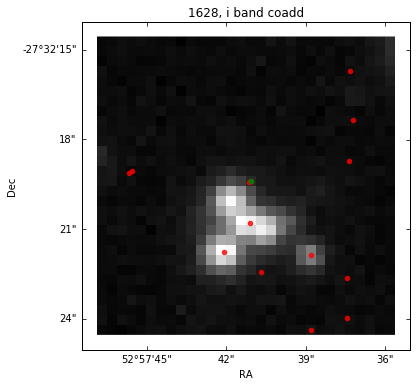

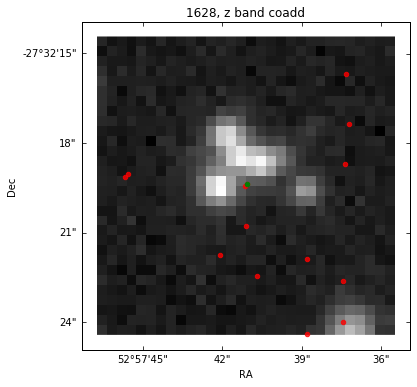

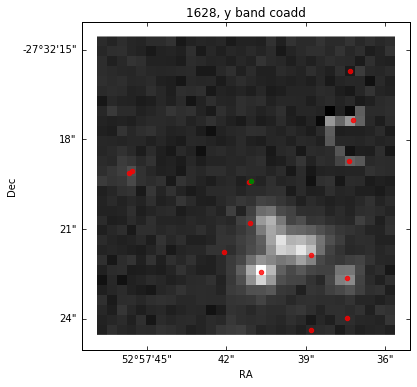

In [5]:
run plot_sources 1628

### Gif Movies
Using my [cineaste.py script](https://github.com/jchiang87/desc_projects/blob/master/twinkles/cineaste.py), I made a movie of this field in u-band:
![ObjectId 1628](objectId_1628.gif)